# ReproductionExperiment_CaliforniaSmoking
- This note is an attempt to reproduce the original paper. 
- Documentation will be added later.
- Original paper : 
Arkhangelsky, Dmitry, et al. Synthetic difference in differences. No. w25532. National Bureau of Economic Research, 2019. https://www.nber.org/papers/w25532
- Reference slide: 
David Hirshberg (Stanford Univ.) "Synthetic difference in differences"
https://davidahirshberg.bitbucket.io/static/synth-did-slides.pdf

In [576]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

sys.path.append(os.path.abspath("../"))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
plt.style.use('ggplot')

from tqdm import tqdm

from synthdid.sdid import SynthDID
from synthdid.sample_data import fetch_CaliforniaSmoking

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [577]:
df = fetch_CaliforniaSmoking()

PRE_TEREM = [1970, 1988]
POST_TEREM = [1989, 2000]

TREATMENT = ["California"]

df.head()

,Alabama,Arkansas,Colorado,Connecticut,Delaware,Georgia,Idaho,Illinois,Indiana,Iowa,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,West Virginia,Wisconsin,Wyoming,California
1970,89.800003,100.300003,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,134.600006,108.500000,...,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997,123.000000
1971,95.400002,104.099998,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,139.300003,108.400002,...,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997,121.000000
1972,101.099998,103.900002,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,149.199997,109.400002,...,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000,123.500000
1973,102.900002,108.000000,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,156.000000,110.599998,...,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997,124.400002
1974,108.199997,109.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,159.600006,116.099998,...,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003,126.699997


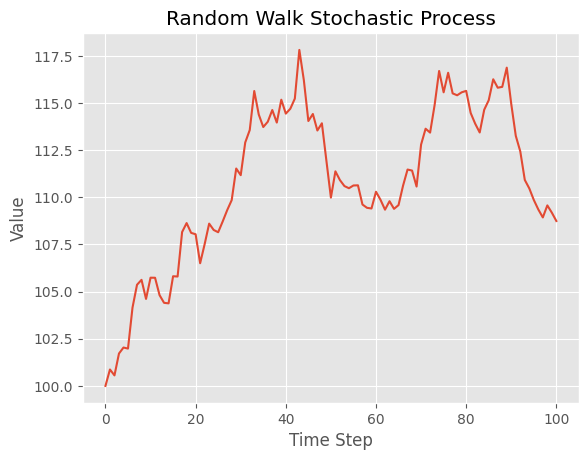

In [578]:
import numpy as np

def generate_random_walk(n_steps, start=0, mu=0, sigma=1, seed=None):
    """
    Generate a random walk stochastic process.
    
    Parameters:
        n_steps (int): Number of steps in the random walk.
        start (float): Starting value of the random walk (default=0).
        mu (float): Mean of the step increments (default=0).
        sigma (float): Standard deviation of the step increments (default=1).
        seed (int): Seed for reproducibility (optional).
        
    Returns:
        np.ndarray: Array of shape (n_steps + 1) containing the random walk values.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Generate random steps (normally distributed)
    steps = np.random.normal(mu, sigma, n_steps)
    
    # Compute cumulative sum and prepend the starting value
    walk = np.concatenate([[start], steps]).cumsum()
    
    return walk


# Generate a random walk with 100 steps (seed for reproducibility)
random_walk = generate_random_walk(n_steps=100, start=0) + 100

# Plot the random walk
import matplotlib.pyplot as plt
plt.plot(random_walk)
plt.title("Random Walk Stochastic Process")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.show()

In [579]:
df

,Alabama,Arkansas,Colorado,Connecticut,Delaware,Georgia,Idaho,Illinois,Indiana,Iowa,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,West Virginia,Wisconsin,Wyoming,California
1970,89.800003,100.300003,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,134.600006,108.500000,...,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997,123.000000
1971,95.400002,104.099998,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,139.300003,108.400002,...,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997,121.000000
1972,101.099998,103.900002,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,149.199997,109.400002,...,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000,123.500000
1973,102.900002,108.000000,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,156.000000,110.599998,...,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997,124.400002
1974,108.199997,109.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,159.600006,116.099998,...,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003,126.699997
1975,111.699997,114.800003,131.000000,110.199997,147.600006,122.900002,123.300003,131.800003,162.399994,120.500000,...,113.500000,117.400002,116.000000,75.800003,155.500000,152.699997,123.199997,113.500000,160.699997,127.099998
1976,116.199997,119.099998,134.199997,113.400002,153.000000,125.900002,125.099998,134.399994,166.600006,124.400002,...,116.699997,121.699997,121.400002,77.900002,171.100006,158.100006,129.699997,115.400002,161.500000,128.000000
1977,117.099998,122.599998,132.000000,117.300003,153.300003,127.900002,125.000000,134.000000,173.000000,125.500000,...,115.599998,124.599998,124.199997,78.000000,169.399994,157.699997,133.899994,117.199997,160.399994,126.400002
1978,123.000000,127.300003,129.199997,117.500000,155.500000,130.600006,122.800003,136.699997,150.899994,127.099998,...,116.900002,127.300003,126.599998,79.599998,162.399994,155.899994,131.600006,116.699997,160.300003,126.099998
1979,121.400002,126.500000,131.500000,117.400002,150.199997,131.000000,117.500000,135.300003,148.899994,124.199997,...,117.400002,127.199997,126.400002,79.099998,160.899994,151.800003,122.099998,117.099998,168.600006,121.900002


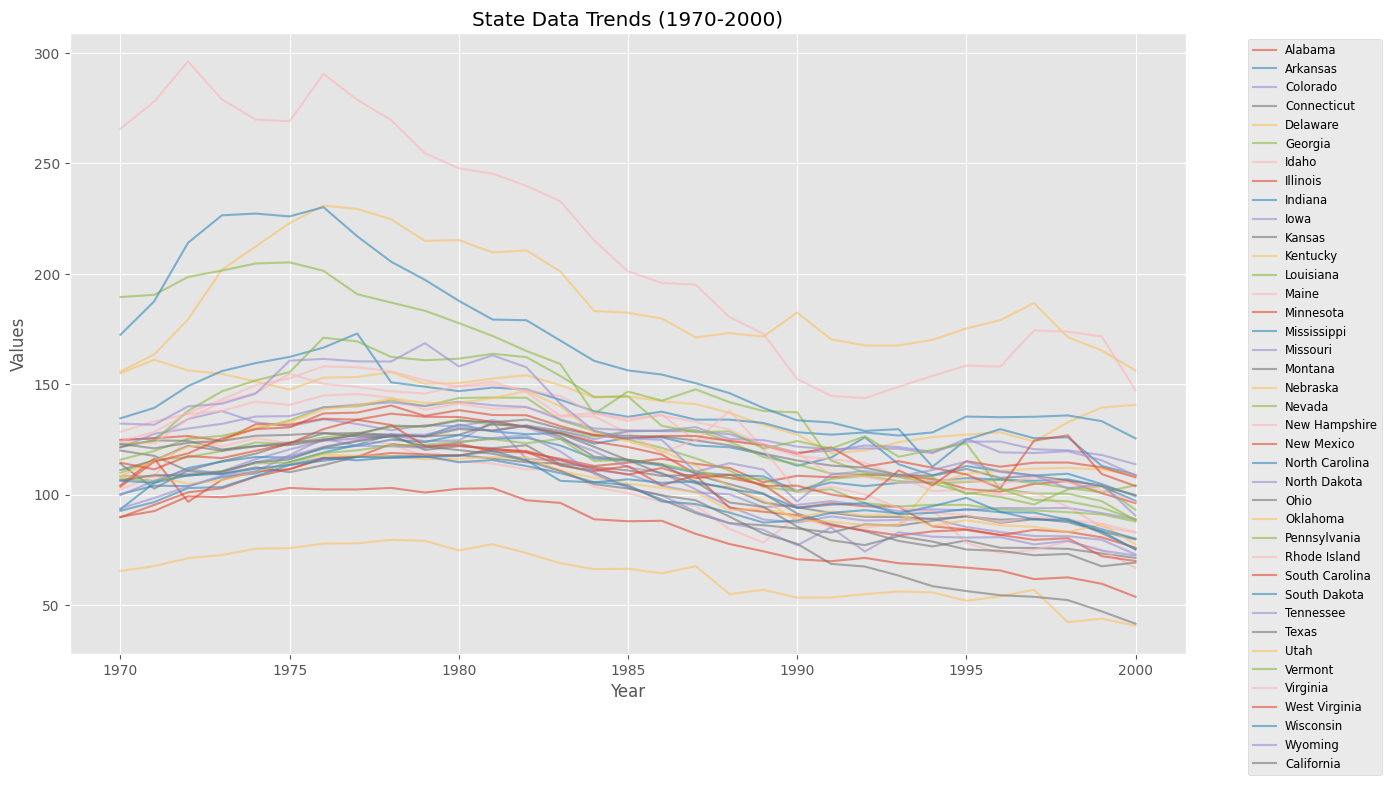

In [580]:
df.plot(kind='line', figsize=(14, 8), alpha=0.6)
plt.title('State Data Trends (1970-2000)')
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

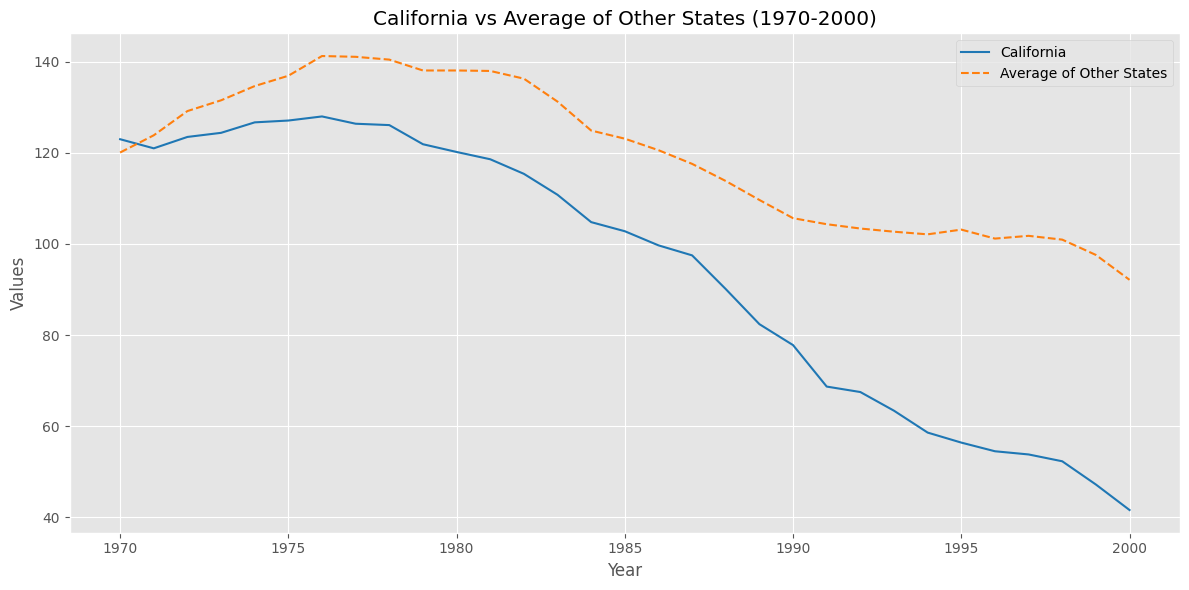

In [581]:
# Extract California's data
california = df['California']

# Compute simple average of all other states
other_states_avg = df.drop(columns=['California']).mean(axis=1)

# Plot
plt.figure(figsize=(12, 6))
california.plot(label='California', color='tab:blue')
other_states_avg.plot(label='Average of Other States', color='tab:orange', linestyle='--')

plt.title('California vs Average of Other States (1970-2000)')
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [582]:
melt_df = pd.melt(
    df.reset_index().rename(columns={"index": "year"}),
    id_vars="year",
    value_name="consumption",
    var_name="state",
)
melt_df["is_California"] = melt_df["state"] == "California"
melt_df

melt_df

,year,state,consumption,is_California
0,1970,Alabama,89.800003,False
1,1971,Alabama,95.400002,False
2,1972,Alabama,101.099998,False
3,1973,Alabama,102.900002,False
4,1974,Alabama,108.199997,False
...,...,...,...,...
1204,1996,California,54.500000,True
1205,1997,California,53.799999,True
1206,1998,California,52.299999,True
1207,1999,California,47.200001,True


- As you can see from the chart below, `the parallel trend assumption` required by DID does not hold.
- The usual solution is to use `Synthetic Control Methods`, but in this case we will use `Synthetic Difference in Differences`.
- This data set is a very famous data set for Synthetic Control Methods. For a more detailed explanation, please refer to the following excellent article

 (see) [15 - Synthetic Control](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html) in "Causal Inference for The Brave and True."

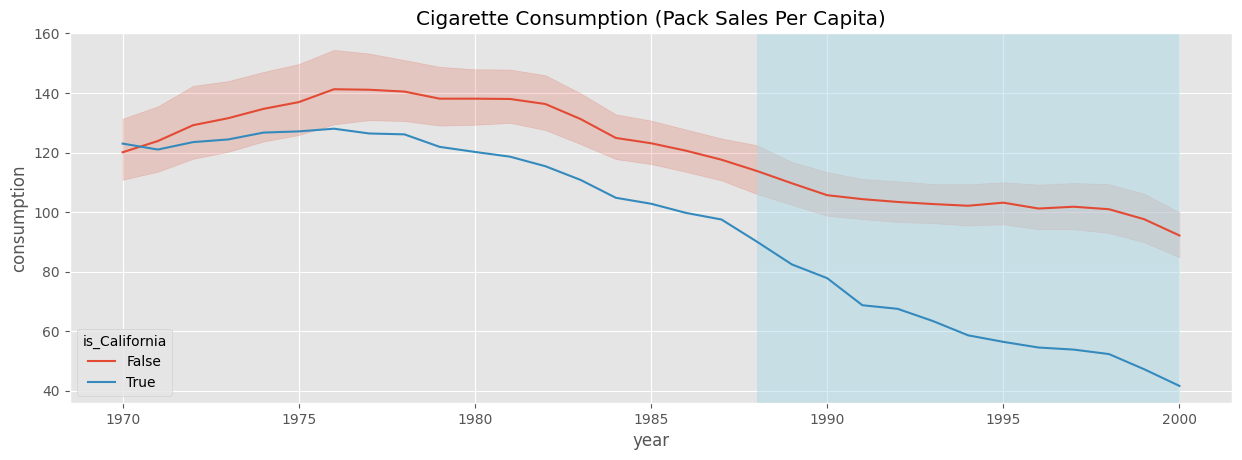

In [583]:
fig, ax = plt.subplots()
fig.set_figwidth(15)

sns.lineplot(x="year", y="consumption", hue="is_California", data=melt_df, ax=ax)

ax.axvspan(1988, 2000, alpha=0.5, color="lightblue")

plt.title("Cigarette Consumption (Pack Sales Per Capita)")
plt.show()

## Synthetic difference in differences
- In the following, we will try to reproduce the original paper using the method of pysynthdid.

In [584]:
sdid = SynthDID(df, PRE_TEREM, POST_TEREM, TREATMENT)
sdid.fit()

In [585]:
sdid.df.head()

,Alabama,Arkansas,Colorado,Connecticut,Delaware,Georgia,Idaho,Illinois,Indiana,Iowa,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,West Virginia,Wisconsin,Wyoming,California
1970,89.800003,100.300003,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,134.600006,108.500000,...,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997,123.000000
1971,95.400002,104.099998,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,139.300003,108.400002,...,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997,121.000000
1972,101.099998,103.900002,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,149.199997,109.400002,...,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000,123.500000
1973,102.900002,108.000000,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,156.000000,110.599998,...,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997,124.400002
1974,108.199997,109.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,159.600006,116.099998,...,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003,126.699997


In [586]:
sdid.hat_omega_gsc

array([0.00000000e+00, 0.00000000e+00, 8.16725871e-02, 1.25105149e-01,
       0.00000000e+00, 5.55278885e-19, 4.33520107e-18, 7.97181464e-02,
       0.00000000e+00, 0.00000000e+00, 9.69604024e-02, 9.28771448e-19,
       0.00000000e+00, 5.82030376e-18, 0.00000000e+00, 1.52308037e-17,
       0.00000000e+00, 1.07338761e-01, 1.30634925e-01, 1.70887167e-01,
       4.34357804e-02, 3.52576074e-02, 1.32656498e-17, 0.00000000e+00,
       1.19941439e-17, 1.07709966e-17, 0.00000000e+00, 6.94711774e-19,
       0.00000000e+00, 1.86425605e-17, 1.11438966e-17, 0.00000000e+00,
       1.10109233e-01, 0.00000000e+00, 8.18680754e-18, 1.88802405e-02,
       0.00000000e+00, 4.72147217e-18])

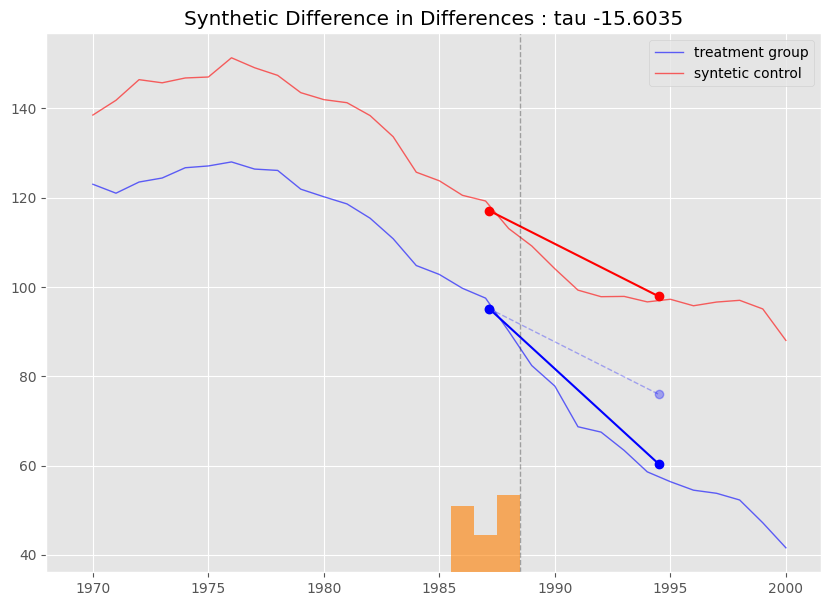

In [587]:
sdid.plot(model="sdid")

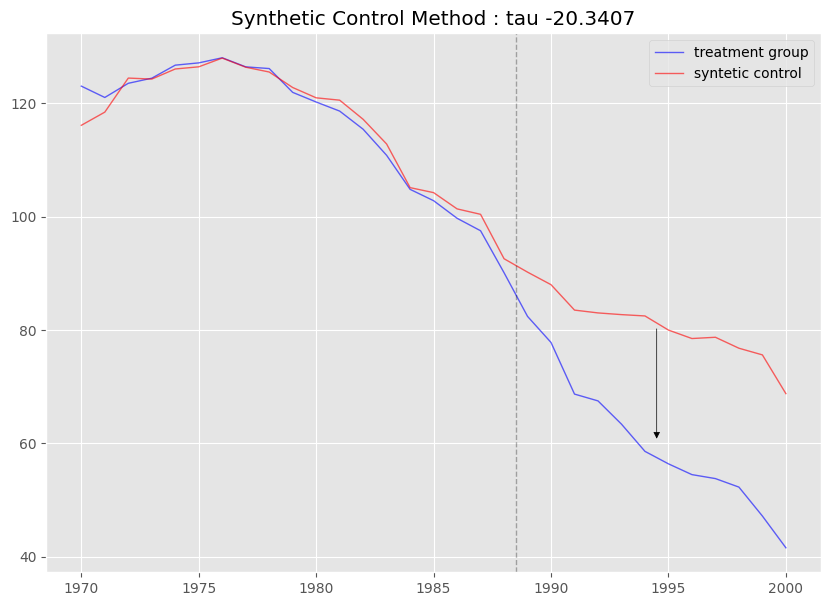

In [588]:
sdid.plot(model="sc")

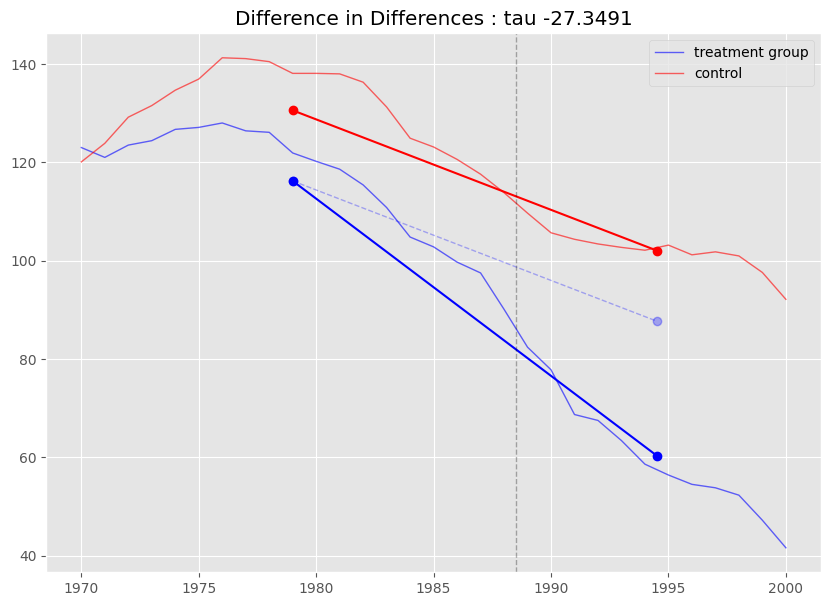

In [589]:
sdid.plot(model="did")

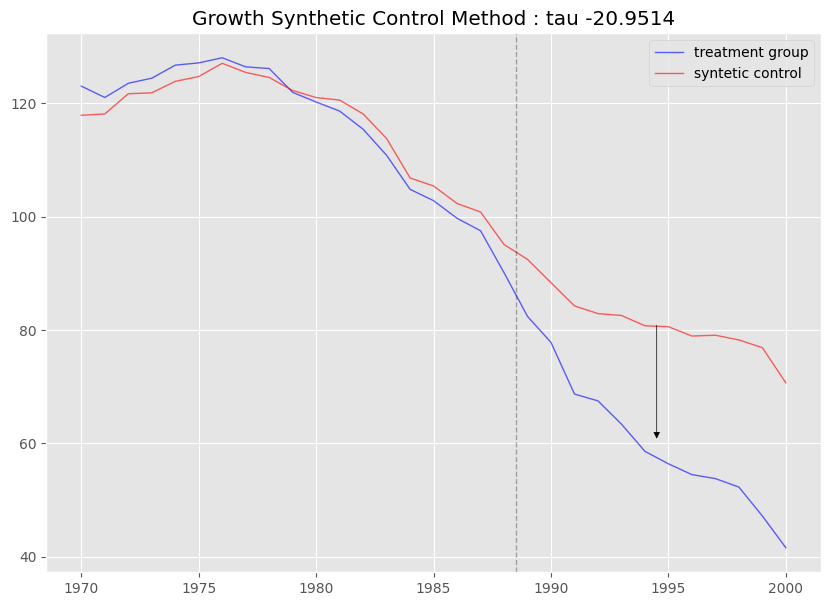

In [590]:
sdid.plot(model="gsc")

## Confirmation of differences in estimated parameters 

<img src="fig/original_lambda.png" style="width:500px;">

<img src="fig/original_omega.png" style="width:300px;">
original paper 7.2 Unit/time weights for California

### (1) : omega
- In both ADH(Classic) SC and SDID, omega is able to confirm that the results were mostly consistent with the original paper.
- For omega in SDID, the weight for `Arkansasu` is 0.03 in the original paper, but is estimated to be 0 in this package pysyndid.
- The weight table in the original paper exceeds 1 when all the weights are added together, so it is probably a typo.
- In the R package, the weight of `Arkansasu` is estimated to be 0 as in this package pysyndid.

<img src="fig/r_synthdid_result.png" style="width:400px;">

- R pkg : [synthdid](https://github.com/synth-inference/synthdid)
- script > notebook/Rsythdid.Rmd

In [591]:
test_omega = pd.read_csv("../test/test_data/omega_CalifolinaSmoking.csv")

In [592]:
hat_omega_sc = sdid.estimated_params(model="sc")

hat_omega_gsc = sdid.estimated_params(model="gsc")

In [593]:
hat_omega_sdid, hat_lambda_sdid = sdid.estimated_params(model="sdid")

In [594]:
omega_result = pd.merge(test_omega, hat_omega_sdid, left_on="state", right_on="features", how="left")

omega_result = pd.merge(omega_result, hat_omega_sc, left_on="features", right_on="features", how="left")

omega_result = pd.merge(omega_result, hat_omega_gsc, left_on="features", right_on="features", how="left")

In [595]:
sdid.hat_omega.shape

df.shape

(31, 39)

In [596]:
omega_result = omega_result.rename(
    columns={
        "omega_ADH": "original_sc",
        "omega_sdid": "original_sdid",
        "sdid_weight": "pysdid_sdid",
        "sc_weight": "pysdid_sc",
        "gsc_weight": "pysdid_gsc"
    }
).drop("features",axis=1)

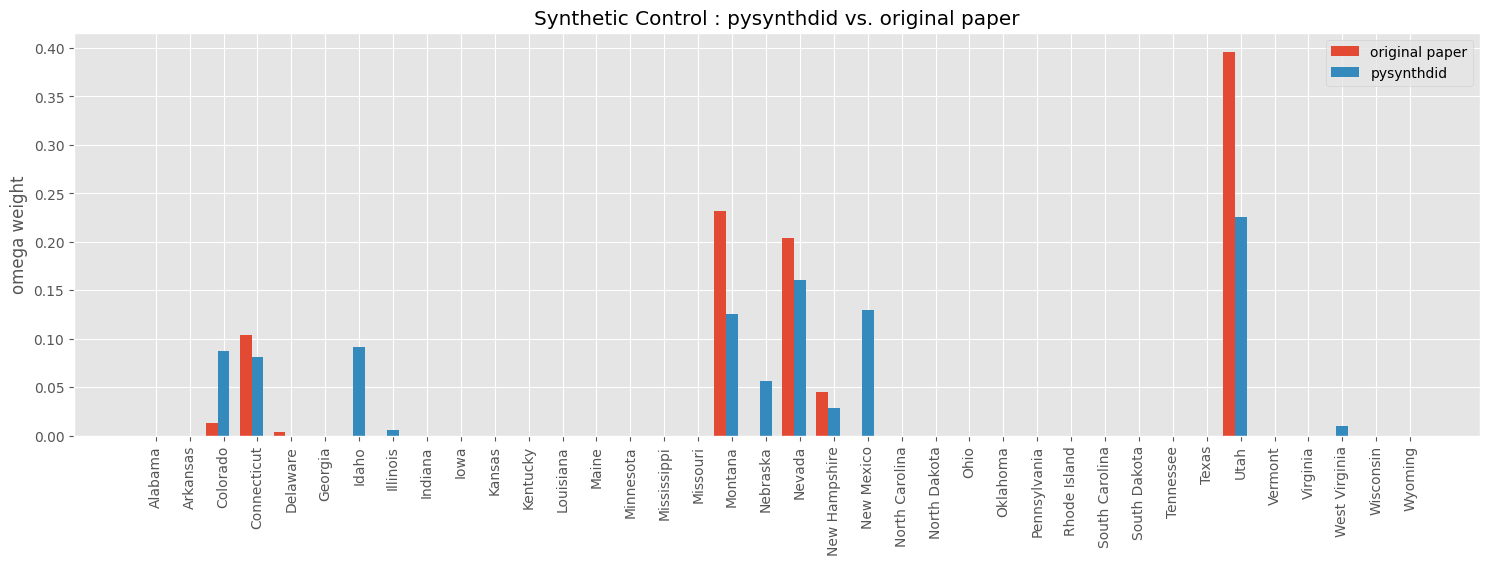

In [597]:
fig = plt.figure()
fig.set_figwidth(15)
ax = fig.add_subplot(1, 1, 1)
width = 0.35
ind = np.arange(len(omega_result))
ax.bar(ind - width, omega_result["original_sc"], width, label="original paper")
ax.bar(ind, omega_result["pysdid_sc"], width, label="pysynthdid")

ax.set_xticks(ind)
ax.set_xticklabels(omega_result["state"].values)
ax.legend()
ax.set_ylabel("omega weight")
ax.set_title("Synthetic Control : pysynthdid vs. original paper")

fig.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [598]:
print("Synth. Control :")
error_sc_omega = np.sqrt(omega_result.eval("original_sc - pysdid_sc") ** 2).sum()
print("error form original paper: ", error_sc_omega)
adh_corr, _p = spearmanr(omega_result["original_sc"], omega_result["pysdid_sc"])
print("corr. with original paper : ", adh_corr)

Synth. Control :
error form original paper:  0.7330000000000001
corr. with original paper :  0.6668826084691242


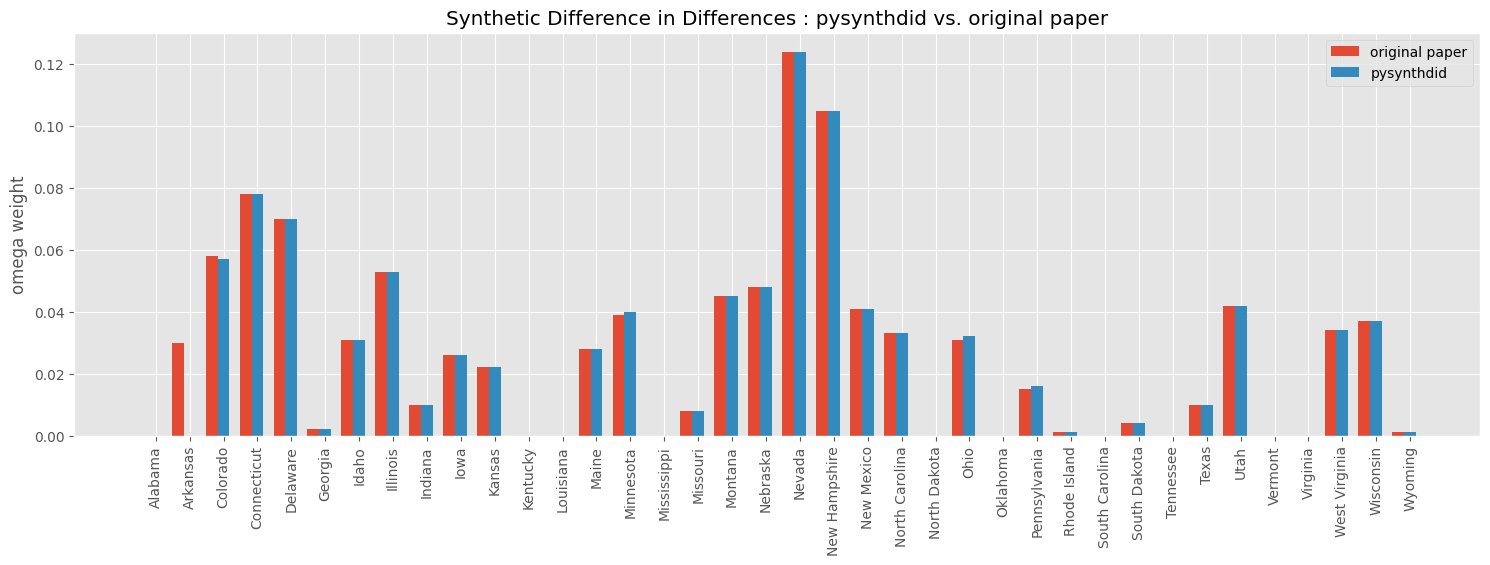

In [599]:
fig = plt.figure()
fig.set_figwidth(15)
ax = fig.add_subplot(1, 1, 1)
width = 0.35
ind = np.arange(len(omega_result))
ax.bar(ind - width, omega_result["original_sdid"], width, label="original paper")
ax.bar(ind, omega_result["pysdid_sdid"], width, label="pysynthdid")

ax.set_xticks(ind)
ax.set_xticklabels(omega_result["state"].values)
ax.legend()
ax.set_ylabel("omega weight")
ax.set_title("Synthetic Difference in Differences : pysynthdid vs. original paper")
fig.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [600]:
omega_result

,state,original_sc,original_sdid,pysdid_sdid,pysdid_sc,pysdid_gsc
0,Alabama,0.000,0.000,0.000,0.000,0.000
1,Arkansas,0.000,0.030,0.000,0.000,0.000
2,Colorado,0.013,0.058,0.057,0.087,0.082
3,Connecticut,0.104,0.078,0.078,0.081,0.125
4,Delaware,0.004,0.070,0.070,0.000,0.000
5,Georgia,0.000,0.002,0.002,0.000,0.000
6,Idaho,0.000,0.031,0.031,0.091,0.000
7,Illinois,0.000,0.053,0.053,0.006,0.080
8,Indiana,0.000,0.010,0.010,0.000,0.000
9,Iowa,0.000,0.026,0.026,0.000,0.000


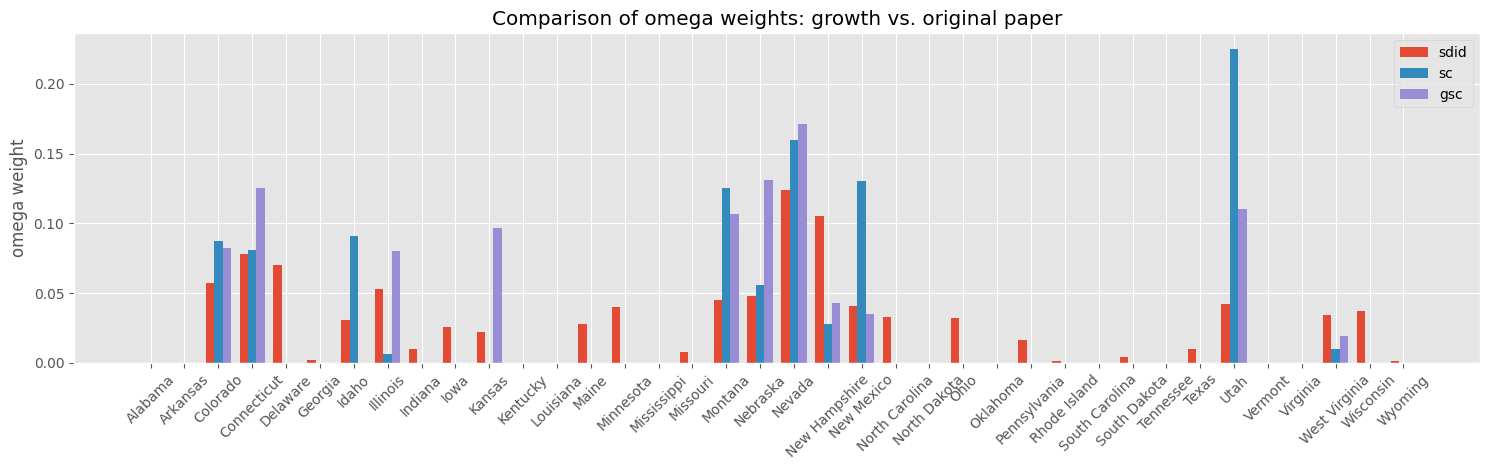

In [601]:
fig = plt.figure()
fig.set_figwidth(15)
ax = fig.add_subplot(1, 1, 1)

width = 0.25  # Reduced width for three bars per group
ind = np.arange(len(omega_result))

# Plot each bar with proper offset
ax.bar(ind - width, omega_result["pysdid_sdid"], width, label="sdid")
ax.bar(ind, omega_result["pysdid_sc"], width, label="sc")
ax.bar(ind + width, omega_result["pysdid_gsc"], width, label="gsc")  # Shifted right

# Set ticks and labels
ax.set_xticks(ind)
ax.set_xticklabels(omega_result["state"].values)

# Improve layout
ax.legend()
ax.set_ylabel("omega weight")
ax.set_title("Comparison of omega weights: growth vs. original paper")
plt.xticks(rotation=45)  # Less extreme rotation for readability
plt.tight_layout()
plt.show()

In [602]:
print(f"Synth. Diff in Diff (zeta= {sdid.zeta} ):")
error_sdid_omega = np.sqrt(omega_result.eval("original_sdid- pysdid_sdid") ** 2).sum()
print("error form original paper: ",  error_sdid_omega)
sdid_corr, _p = spearmanr(omega_result["original_sdid"], omega_result["pysdid_sdid"])
print("corr. with original paper : ",  sdid_corr)

Synth. Diff in Diff (zeta= 10.218754521078738 ):
error form original paper:  0.034
corr. with original paper :  0.9698165835851581


In [603]:
omega_result.drop("state", axis=1).sum()

original_sc      0.998
original_sdid    1.026
pysdid_sdid      0.998
pysdid_sc        0.999
pysdid_gsc       1.000
dtype: float64

### (2) : lambda
- ` lambda` is almost identical to the original paper

In [604]:
test_lambda = pd.read_csv("../test/test_data/lambda_CalifolinaSmoking.csv")

In [605]:
lambda_result = pd.merge(
    test_lambda, hat_lambda_sdid, left_on="year", right_on="time", how="left"
)
del lambda_result["time"]

In [606]:
cm = sns.light_palette("green", as_cmap=True)
lambda_result.rename(
    columns={"lambda_sdid": "original paper", "sdid_weight": "pysynthdid"}
).style.background_gradient(cmap=cm,subset=['original paper','pysynthdid'])

,year,original paper,pysynthdid
0,1970,0.000000,0.000000
1,1971,0.000000,0.000000
2,1972,0.000000,0.000000
3,1973,0.000000,0.000000
4,1974,0.000000,0.000000
5,1975,0.000000,0.000000
6,1976,0.000000,0.000000
7,1977,0.000000,0.000000
8,1978,0.000000,0.000000
9,1979,0.000000,0.000000


## Confidence interval
- This package calculates CI based on the `placebo` method

In [607]:
%timeit
sdid.cal_se(algo="placebo", replications=500)

  0%|          | 2/500 [00:03<14:05,  1.70s/it]


KeyboardInterrupt: 

In [ ]:
sdid.summary(model="sdid")

------------------------------------------------------------
Syntetic Difference in Differences

point estimate: -15.604  (9.650)
95% CI (-34.517, 3.310)


In [ ]:
sdid.summary(model="sc")

------------------------------------------------------------
Syntetic Control Method

point estimate: -20.341  (10.918)
95% CI (-41.740, 1.059)


In [ ]:
sdid.summary(model="gsc")

------------------------------------------------------------
Syntetic Control Method

point estimate: -21.831  (11.849)
95% CI (-45.055, 1.393)


In [ ]:
sdid.summary(model="did")

------------------------------------------------------------
Difference in Differences

point estimate: -27.349  (17.633)
95% CI (-61.911, 7.212)


In [ ]:
# %timeit
# sdid_growth.cal_se(algo="placebo", replications=200)

In [ ]:
# sdid_growth.summary(model="sdid")

In [ ]:
# sdid_growth.summary(model="sc")

In [ ]:
# sdid_growth.summary(model="did")

## AA test
- The following figure is a reproduction of the following slide presentation by Susan Athey (Stanford University)
- slide: Susan Athey "**Synthetic Differences in Differences.**" https://www.aeaweb.org/conference/2020/preliminary/powerpoint/fnQr9QDs
- This was estimated using the 8 years prior to the California intervention as a pseudo-intervention period (so `the estimated potential outcome = acutal outcome` should hold).
- As shown in the following two charts, the results are generally consistent with those in the slide.

In [ ]:
PRE_TEREM2 = [1970, 1979]
POST_TEREM2 = [1980, 1988]

sdid_cal = SynthDID(df, PRE_TEREM2, POST_TEREM2,  ["California"])
sdid_nh = SynthDID(df, PRE_TEREM2, POST_TEREM2, ["New Hampshire"])
sdid_nevada = SynthDID(df, PRE_TEREM2, POST_TEREM2, ["Nevada"])


sdid_cal.fit()
sdid_nh.fit()
sdid_nevada.fit()

# This is a markdown image

<!-- <img src="fig/california.png"> -->

state : California
        actual_y         did          sc        sdid         gsc
1980  120.199997  129.181842  124.447646  121.168955  123.544869
1981  118.599998  129.079210  124.387260  120.895830  123.040908
1982  115.400002  127.387105  121.815668  118.266178  120.624308
1983  110.800003  122.342369  117.569003  113.799404  116.652233
1984  104.800003  115.995000  111.317918  106.673647  109.854943
1985  102.800003  114.208158  110.833163  105.522889  109.573995
1986   99.699997  111.687105  108.225485  102.511658  106.988541
1987   97.500000  108.679211  107.196701  101.286585  105.572777
1988   90.099998  104.916052  101.231132   96.143952  103.194610


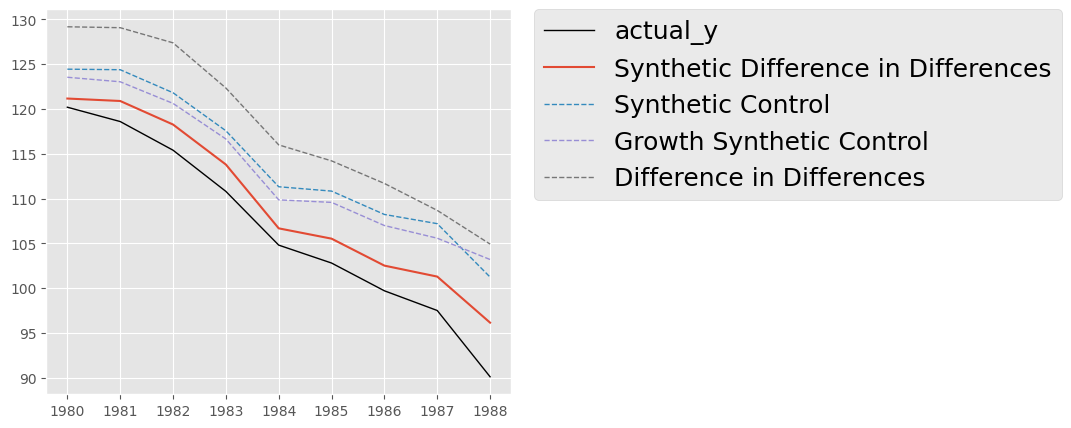

In [ ]:
print("state : California")
sdid_cal.comparison_plot(figsize=(6,5))

# This is also a markdown image

<!-- <img src="fig/NewHampshire.png"> -->

state : New Hampshire
        actual_y         did          sc        sdid         gsc
1980  247.800003  280.099739  187.829324  253.448167  271.330028
1981  245.399994  280.018159  179.329374  251.932748  269.649792
1982  239.800003  278.389212  179.029062  250.264535  268.507594
1983  232.899994  273.405003  169.828145  245.072519  258.462549
1984  215.100006  267.368160  160.626898  235.314479  246.063743
1985  201.100006  265.897107  156.326682  235.470502  240.683396
1986  195.899994  263.431318  154.426143  232.505111  234.540370
1987  195.100006  260.386581  150.525688  231.151861  228.822010
1988  180.399994  256.815528  146.025088  225.430026  220.022189


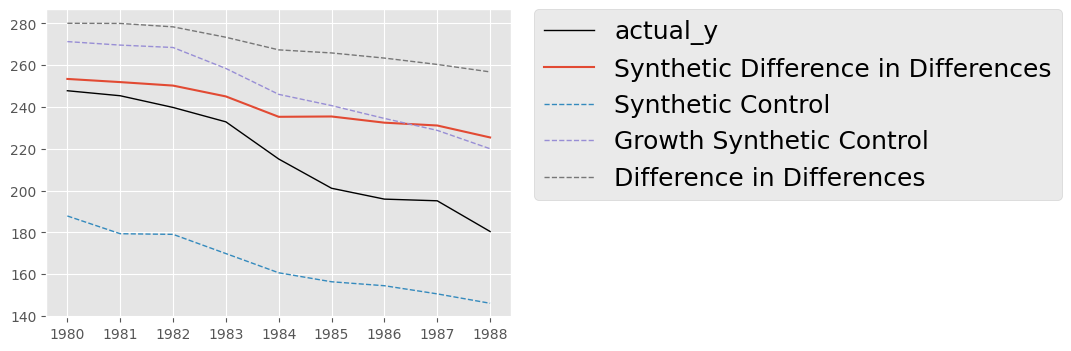

In [ ]:
print("state : New Hampshire")
sdid_nh.comparison_plot(figsize=(6,4))

state : Nevada
        actual_y         did          sc        sdid         gsc
1980  177.699997  199.962368  180.335987  180.801313  191.872469
1981  171.899994  199.970263  177.702242  178.961866  190.741334
1982  165.100006  198.372894  175.375070  176.701177  187.303445
1983  159.199997  193.362369  168.968453  171.297771  179.038590
1984  136.600006  187.451842  159.156652  163.605115  171.999776
1985  146.699997  185.346579  153.150774  158.988602  167.228300
1986  142.600006  182.851842  150.090390  156.288678  164.490194
1987  147.699997  179.651843  147.547521  153.161824  157.950554
1988  141.899994  175.846579  139.821657  146.654092  154.257009


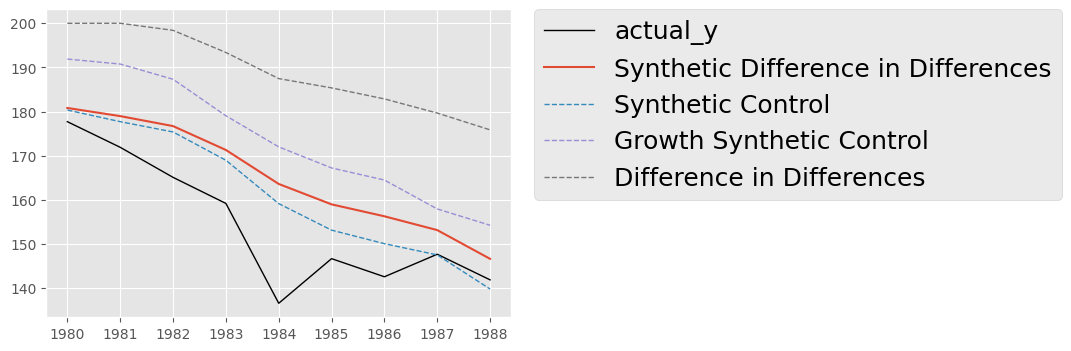

In [ ]:
print("state : Nevada")
sdid_nevada.comparison_plot(figsize=(6,4))

- The above work was applied to all the states.
- As shown in the following chart, the proposed method, `Synthetic Difference in Differences (pysynthdid)`, shows better results than the classical `Syntetic Control Methods`.

In [ ]:
state_list = df.columns

result_rmse_list = []
state_tau_dict = {}

for _state in tqdm(state_list):
    _sdid = SynthDID(df, PRE_TEREM2, POST_TEREM2, [_state])
    _sdid.fit()

    _outcome = pd.DataFrame({"actual_y": _sdid.target_y()})

    _outcome["did"] = _sdid.did_potential_outcome()
    _outcome["sc"] = _sdid.sc_potential_outcome()
    _outcome["sdid"] = _sdid.sdid_potential_outcome()
    _outcome["gsc"] = _sdid.gsc_potential_outcome()
    _outcome = _outcome.loc[POST_TEREM2[0] : POST_TEREM2[1]]

    _rmse = np.sqrt((_outcome.mean() - _outcome.mean()["actual_y"]) ** 2)
    _rmse = pd.DataFrame(_rmse).T[["did", "sc", "sdid", "gsc"]]
    _rmse.index = [_state]

    result_rmse_list.append(_rmse)
    
    state_tau_dict[_state] = {
        "did": _sdid.hat_tau(model="did"),
        "sc": _sdid.hat_tau(model="sc"),
        "sdid": _sdid.hat_tau(model="sdid"),
        "gsc": _sdid.hat_tau(model="gsc")
    }

100%|██████████| 39/39 [01:08<00:00,  1.76s/it]


In [ ]:
result_rmse = pd.concat(result_rmse_list)

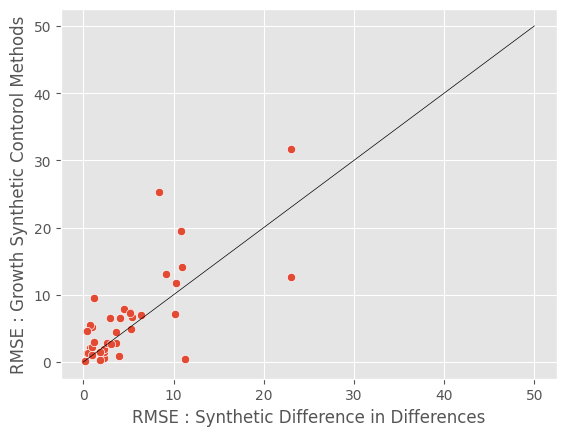

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
_x = np.linspace(0, 50, 30)
_y = _x
sns.scatterplot(data=result_rmse, x="sdid", y="gsc", ax = ax)
ax.plot(_x, _y, color='black',  linestyle='solid',linewidth = 0.5)
ax.set_xlabel("RMSE : Synthetic Difference in Differences")
ax.set_ylabel("RMSE : Growth Synthetic Contorol Methods")
#ax.set_xlim(0, 25)
#ax.set_ylim(0, 55)
plt.show()

In [ ]:
result_rmse.mean()

did     9.436689
sc      6.837780
sdid    4.959939
gsc     6.306544
dtype: float64

In [ ]:
result_rmse

,did,sc,sdid,gsc
Alabama,15.103918,5.994405,5.132013,7.480506
Arkansas,19.887690,11.416243,9.111552,13.079472
Colorado,6.820467,0.621704,0.398527,1.264036
Connecticut,4.579619,1.815712,2.255077,0.695212
Delaware,0.676257,8.699271,10.101755,7.119026
Georgia,14.084444,7.924366,6.333328,7.006592
Idaho,9.490031,3.588148,2.291020,0.543660
Illinois,0.545117,1.594518,3.558184,2.769453
Indiana,6.748625,4.713951,11.264603,0.374297
Iowa,2.342250,3.235656,2.266314,1.471806


In [ ]:
# Confirmation calculation
(pd.DataFrame(state_tau_dict).T**2).apply(np.sqrt).mean()

did     9.436689
sc      6.837780
sdid    4.959930
gsc     6.306544
dtype: float64

In [ ]:
print("Done")

Done


In [ ]:
sdid.target_y()

1970    123.000000
1971    121.000000
1972    123.500000
1973    124.400002
1974    126.699997
1975    127.099998
1976    128.000000
1977    126.400002
1978    126.099998
1979    121.900002
1980    120.199997
1981    118.599998
1982    115.400002
1983    110.800003
1984    104.800003
1985    102.800003
1986     99.699997
1987     97.500000
1988     90.099998
1989     82.400002
1990     77.800003
1991     68.699997
1992     67.500000
1993     63.400002
1994     58.599998
1995     56.400002
1996     54.500000
1997     53.799999
1998     52.299999
1999     47.200001
2000     41.599998
dtype: float64

In [ ]:
from causallib.estimation import PropensityMatching